# Data collection and LPA region extraction

*Author: Yifei Wang (yifei.wang.yw2245@yale.edu)*

*Date: 2025.12.25*

### Motivation: 

Lipoprotein(a) (**LPA**) is a medically important locus with strong associations to cardiovascular disease risk. A defining feature of the LPA gene is the **Kringle IV type 2 (KIV-2) copy number repeat**, which exhibits extreme structural variability across individuals and haplotypes. This variability is poorly captured by short-read sequencing and is inconsistently represented in linear reference genomes, including GRCh38.

The goals of this project are therefore to:
1. Leverage pangenome-scale, haplotype-resolved assemblies to accurately localize the LPA locus across individuals.
2. Characterize and visualize **KIV-2 repeat structure and copy number diversity** across haplotypes, laying the groundwork for downstream genotyping and population-level analysis.


Utilize the data from [OpenHGL](https://github.com/lh3/OpenHGL?tab=readme-ov-file) and gain new insight on LPA region; LPA region is .... ..

### Process:
1. Download the `agc` from [579 human genome assemblies](https://github.com/lh3/human-asm) and annotation files by liftoff from [HPRC repo](https://github.com/human-pangenomics/hprc_intermediate_assembly/tree/main/data_tables/annotation/liftoff) 

### Data Sources

| Name  | Version     | nAsm | Description                                   |
|------|-------------|------|-----------------------------------------------|
| CHM13 | 2.0         | 1    | Telomere-to-telomere reference assembly        |
| CN1   | 1.0.1       | 2    | Chinese Han individual                         |
| KSA001| 1.1.0       | 2    | Saudi Arabian individual                      |
| I002C | 0.7         | 2    | Indian individual                              |
| KOREF1| 2025        | 2    | Korean reference genome                        |
| YAO   | 2.0         | 2    | Chinese individual                             |
| HPRC  | r2-v1.0.1   | 464  | Human Pangenome Reference Consortium assemblies|
| APR   | v1          | 104  | UAE-based Arab Pangenome Reference             |

**Note:** In the first round of analysis, we restrict the dataset to the **464 haplotypes from HPRC**.


2. Extract LPA region using liftoff annotation；

3. Insight into the KIV-2 copy number repeats across individuals and haplotype。

### Results:

See below 


### Conclusion:

TBD



### 1. Download HPRC annotation files

In [ ]:
cut -d, -f4 liftoff_genes_hprc_r2_v1.0.index.csv | tail -n +2 > liftoff_urls.txt

Submit 'download_HPRC_liftoff.sh'

In [ ]:
#!/bin/bash
#SBATCH --job-name=HPRC_liftoff
#SBATCH --partition=day
#SBATCH --time=01:00:00
#SBATCH --mem=10G
#SBATCH --cpus-per-task=1
#SBATCH --array=1-464%20
#SBATCH --output=logs/%A_%a.out
#SBATCH --error=logs/%A_%a.err

set -euo pipefail
module load awscli || true

OUTDIR=/home/yw2245/project_pi_hc895/yw2245/projects/lpa_genotyping/data/openhgl/HPRC/liftoff_gff3
mkdir -p ${OUTDIR} logs

URL=$(sed -n "${SLURM_ARRAY_TASK_ID}p" /home/yw2245/project_pi_hc895/yw2245/projects/lpa_genotyping/data/openhgl/HPRC/liftoff_urls.txt)
FNAME=$(basename ${URL})

aws s3 cp ${URL} ${OUTDIR}/${FNAME} --no-sign-request


### 2. Extract LPA region using liftoff annotation

In [ ]:
#!/bin/bash
#SBATCH --job-name=HPRC_fa
#SBATCH --partition=day
#SBATCH --time=01:00:00
#SBATCH --mem=10G
#SBATCH --cpus-per-task=1
#SBATCH --array=1-464%20
#SBATCH --output=logs/%A_%a.out
#SBATCH --error=logs/%A_%a.err

set -euo pipefail

AGC=/home/yw2245/project_pi_hc895/yw2245/projects/lpa_genotyping/data/openhgl/human579/human579.agc
GFFDIR=/home/yw2245/project_pi_hc895/yw2245/projects/lpa_genotyping/data/openhgl/HPRC/liftoff_gff3
OUTDIR=/home/yw2245/project_pi_hc895/yw2245/projects/lpa_genotyping/data/openhgl/HPRC/LPA_fa
TMPDIR=/home/yw2245/project_pi_hc895/yw2245/projects/lpa_genotyping/data/openhgl/HPRC/tmp_contigs
LIST=${GFFDIR}/gff_list.txt

mkdir -p "$OUTDIR" "$TMPDIR"

# array index to aff
gff=$(sed -n "${SLURM_ARRAY_TASK_ID}p" "$LIST")
sample=$(basename "$gff" .gff3)

echo "Processing $sample"

# Extarct LPA gene
awk -F'\t' '
$3=="gene" && $9 ~ /(^|;)gene_name=LPA(;|$)/ {
    print $1 "\t" $4 "\t" $5 "\t" $7
}
' "$gff" | while read contig start end strand; do

    echo "  LPA on $contig:$start-$end ($strand)"

    contig_fa=${TMPDIR}/${contig}.fa

    if [ ! -f "$contig_fa" ]; then
        agc getctg "$AGC" "$contig" > "${contig_fa}.tmp"
        mv "${contig_fa}.tmp" "$contig_fa"
        sync
        samtools faidx "$contig_fa"
    fi

    out_fa=${OUTDIR}/${sample}_LPA.fa

    if [ "$strand" = "-" ]; then
        samtools faidx -i "$contig_fa" "${contig}:${start}-${end}" >> "$out_fa"
    else
        samtools faidx "$contig_fa" "${contig}:${start}-${end}" >> "$out_fa"
    fi

done

### 3. Insight into the KIV-2 copy number repeats across individuals and haplotype

Follow code from A pan-genome approach to decipher variants in the highly complex tandem repeat of LPA [paper link](https://www.biorxiv.org/content/10.1101/2022.06.08.495395v2.full), [Doker image](https://hub.docker.com/r/cschin/pgr-lpa)

Relative process notebooks: 
1. https://github.com/wangyf1125/genotyping/tree/main/notebooks/00-pLPA-graph.ipynb
2. https://github.com/wangyf1125/genotyping/tree/main/notebooks/01-pLPA-repeat-structure-plot.ipynb
3. https://github.com/wangyf1125/genotyping/tree/main/notebooks/04-pLPA-graph3-FL.ipynb


In [ ]:
cat *_LPA.fa > LPA_HPRC_liftoff_all.fa

In [ ]:
import csv

infile = "/home/yw2245/project_pi_hc895/yw2245/projects/lpa_genotyping/data/openhgl/human579/human579.meta.tsv"
outfile = "/home/yw2245/project_pi_hc895/yw2245/projects/lpa_genotyping/data/openhgl/human579/Tables_from_human579.csv"

pop_map = {
    "EastAsia": "EAS",
    "SouthAsia": "SAS",
    "Africa": "AFR",
    "Europe": "EUR",
    "MiddleEast": "MID",
    "America": "AMR",
    "Oceania": "OCE",
    "Admixed": "ADMIX",
}

with open(infile) as fin, open(outfile, "w", newline="") as fout:
    writer = csv.writer(fout)
    writer.writerow(["Sample", "Haplotype", "Ethnicity", "Source"])

    for line in fin:
        cols = line.strip().split("\t")
        asm = cols[0]
        sample = cols[2]
        region = cols[4]

        if asm.endswith(".pat"):
            hap = "1"
        elif asm.endswith(".mat"):
            hap = "2"
        else:
            continue  # skip CHM13.pri etc.

        eth = pop_map.get(region, "N/A")
        writer.writerow([sample, hap, eth, ""])

print("Written:", outfile)


(-0.5, 5102.5, 18248.5, -0.5)

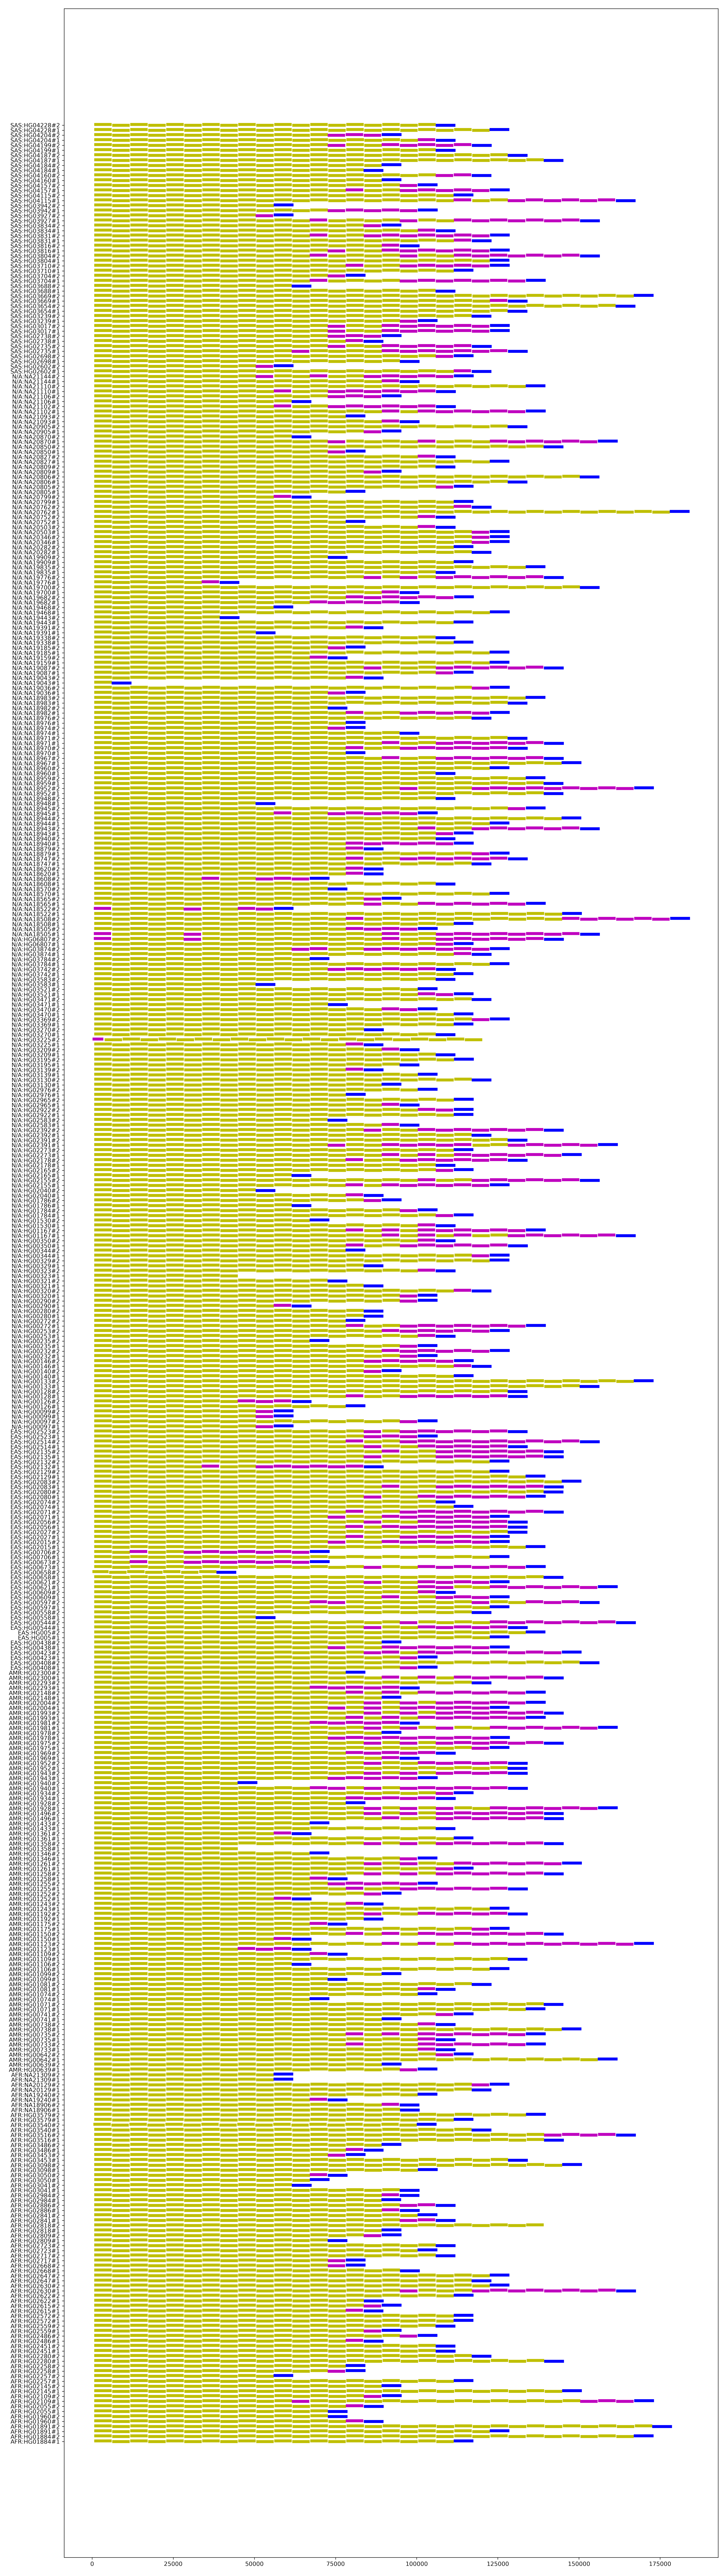

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 80), dpi=200)
plt.imshow(plt.imread("/home/yw2245/scratch60/work/LPA_krigle_repeat_pangenomics-463.png"))
plt.axis("off")

